In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook

import fannypack
from lib import panda_datasets, panda_baseline_models, panda_baseline_training


In [4]:
print("Creating model...")
model = panda_baseline_models.PandaLSTMModel(batch_size=16)
buddy = fannypack.utils.Buddy("lstm_test_reverted_feb22_truncated_unnormalized", model)

Creating model...
[buddy-lstm_test_reverted_feb22_truncated_unnormalized] Using device: cuda
[buddy-lstm_test_reverted_feb22_truncated_unnormalized] No checkpoint found


In [11]:
print("Creating dataset...")
dataset = panda_datasets.PandaParticleFilterDataset(
    'data/gentle_push_100.hdf5',
    subsequence_length=16
)

Creating dataset...

Parsed data: 299 active, 1 inactive
Keeping (inactive): 1


In [12]:
print("Training...")
buddy.set_learning_rate(1e-4)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
model.batch_size = 16
for _ in tqdm_notebook(range(100)):
    for batch_idx, batch in enumerate(tqdm_notebook(dataloader)):
        _, states, observations, _ = fannypack.utils.to_device(
            batch,
            buddy.device
        )

        model.reset_hidden_states(states[:, 0, :])
        predicted_states = model(observations)

        loss = F.mse_loss(predicted_states, states)
        buddy.minimize(loss, checkpoint_interval=500)

        with buddy.log_scope("lstm_training"):
            buddy.log("loss", loss)
            buddy.log("predicted_states_mean", predicted_states.mean())
            buddy.log("predicted_states_std", predicted_states.std())
            buddy.log("label_states_mean", states.mean())
            buddy.log("label_states_std", states.std())

buddy.save_checkpoint()

Training...


[buddy-lstm_test_reverted_feb22_truncated_unnormalized] Saved checkpoint to path: checkpoints/lstm_test_reverted_feb22_truncated_unnormalized-0000000000000500.ckpt



[buddy-lstm_test_reverted_feb22_truncated_unnormalized] Saved checkpoint to path: checkpoints/lstm_test_reverted_feb22_truncated_unnormalized-0000000000001000.ckpt



[buddy-lstm_test_reverted_feb22_truncated_unnormalized] Saved checkpoint to path: checkpoints/lstm_test_reverted_feb22_truncated_unnormalized-0000000000001500.ckpt



[buddy-lstm_test_reverted_feb22_truncated_unnormalized] Saved checkpoint to path: checkpoints/lstm_test_reverted_feb22_truncated_unnormalized-0000000000002000.ckpt





[buddy-lstm_test_reverted_feb22_truncated_unnormalized] Saved checkpoint to path: checkpoints/lstm_test_reverted_feb22_truncated_unnormalized-0000000000002138.ckpt


In [16]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5"
)

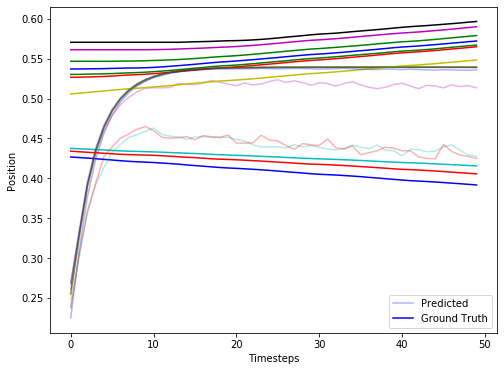

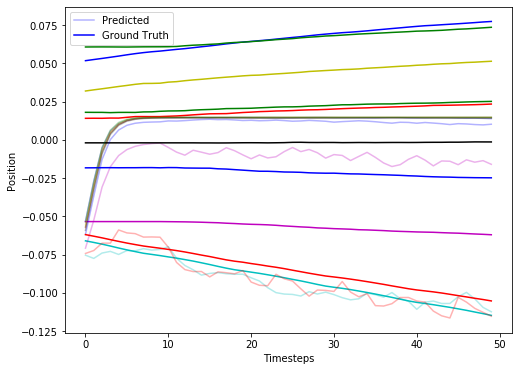

X RMSE:  0.07021170743687388
Y RMSE:  0.033512665501268496


In [17]:
pred, actual = panda_baseline_training.rollout_lstm(model, eval_trajectories)
panda_baseline_training.eval_rollout(pred, actual, plot=True)